In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
import xgboost as xgb
from tqdm.auto import tqdm
from sklearn.utils import shuffle
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, label_binarize, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score, r2_score, mean_squared_error,
    accuracy_score, log_loss, confusion_matrix, classification_report,
    mean_absolute_error, explained_variance_score
)
from sklearn.linear_model import (
    LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet,
    BayesianRidge, PassiveAggressiveRegressor
)
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier,
    RandomForestRegressor, GradientBoostingRegressor
)
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope

In [97]:
#Load the datafile and print out first few rows in the dataset
df = pd.read_csv('../input/steel-industry-energy-consumption/Steel_industry_data.csv')
df.head() 

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


# Data Cleaning

In [99]:
#Drop the index column
df.reset_index(drop=True, inplace=True) 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38544 entries, 0 to 38543
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  38544 non-null  object 
 1   Usage_kWh                             38436 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  38544 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  38544 non-null  float64
 4   CO2(tCO2)                             38544 non-null  float64
 5   Lagging_Current_Power_Factor          38435 non-null  float64
 6   Leading_Current_Power_Factor          38544 non-null  float64
 7   NSM                                   38544 non-null  int64  
 8   WeekStatus                            38544 non-null  object 
 9   Day_of_week                           38544 non-null  object 
 10  Load_Type                             38544 non-null  object 
dtypes: float64(6), 

In [100]:
df.shape

(38544, 11)

In [101]:
# Handling Missing Values:
# Drop rows with missing values
df.dropna(inplace=True)

In [102]:
#Check if there is missing value 
df.isnull().sum().sort_values(ascending=False)

date                                    0
Usage_kWh                               0
Lagging_Current_Reactive.Power_kVarh    0
Leading_Current_Reactive_Power_kVarh    0
CO2(tCO2)                               0
Lagging_Current_Power_Factor            0
Leading_Current_Power_Factor            0
NSM                                     0
WeekStatus                              0
Day_of_week                             0
Load_Type                               0
dtype: int64

In [103]:
# Removing Duplicates:
df.drop_duplicates(inplace=True)

In [104]:
df.shape

(34838, 11)

In [105]:
df.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


In [106]:
numeric_cols = ['Usage_kWh','Lagging_Current_Reactive.Power_kVarh','Leading_Current_Reactive_Power_kVarh','CO2(tCO2)',
                'Lagging_Current_Power_Factor','Leading_Current_Power_Factor','NSM']

# Initialize LocalOutlierFactor
outlier_detector = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
# Fit the detector and get outlier scores
outlier_scores = outlier_detector.fit_predict(df[numeric_cols])
# Filter outliers
df = df[outlier_scores == 1]
df.shape
df.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


In [107]:
df.shape

(31354, 11)

# Data Analysis & Visualizations

In [108]:
df.nunique()

date                                    31354
Usage_kWh                                3109
Lagging_Current_Reactive.Power_kVarh     1884
Leading_Current_Reactive_Power_kVarh      762
CO2(tCO2)                                   8
Lagging_Current_Power_Factor             4870
Leading_Current_Power_Factor             2804
NSM                                       181
WeekStatus                                  2
Day_of_week                                 7
Load_Type                                   3
dtype: int64

In [109]:
# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')

In [110]:
 #Summary statistics of the datase
df.describe()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM
count,31354,31354.000000,31354.000000,31354.000000,31354.000000,31354.000000,31354.000000,3.135400e+04
mean,2018-07-04 11:24:39.084008704,27.356988,13.141614,3.580951,0.011579,79.960870,85.322164,5.570355e+04
min,2018-01-01 00:00:00,2.450000,0.000000,0.000000,0.000000,39.360000,12.500000,0.000000e+00
25%,2018-04-07 12:18:45,3.170000,2.840000,0.000000,0.000000,62.280000,99.922500,2.160000e+04
50%,2018-07-02 11:07:30,4.280000,5.000000,0.000000,0.000000,87.360000,100.000000,4.230000e+04
75%,2018-10-01 13:11:15,51.730000,23.290000,0.610000,0.020000,97.270000,100.000000,6.480000e+04
max,2018-12-31 23:45:00,144.290000,90.680000,27.650000,0.070000,100.000000,100.000000,8.550000e+06
std,NaN,33.093184,16.059418,7.180054,0.016031,18.879457,29.979459,2.729967e+05


In [111]:
cf.go_offline()

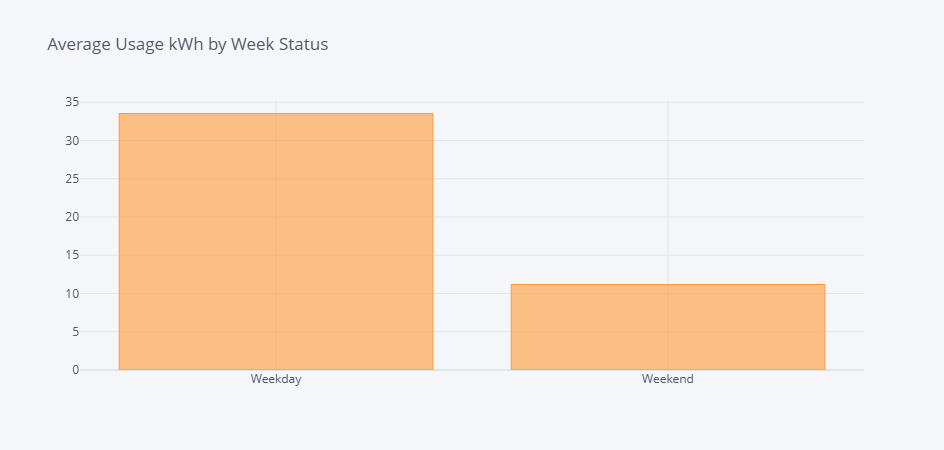

In [112]:
# Bar Plot
df[['WeekStatus', 'Usage_kWh']].groupby('WeekStatus').mean().iplot(kind='bar', title='Average Usage kWh by Week Status')

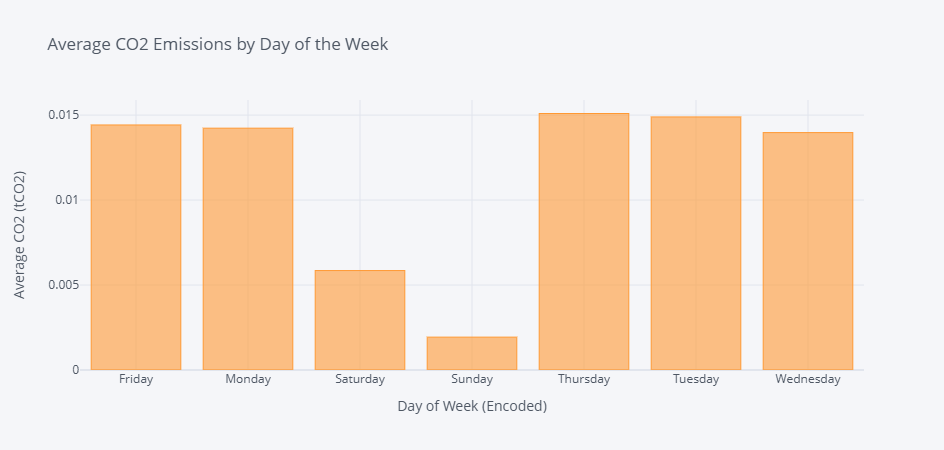

In [113]:
avg_co2_by_day = df.groupby('Day_of_week')['CO2(tCO2)'].mean()
avg_co2_by_day.iplot(kind='bar', title='Average CO2 Emissions by Day of the Week', xTitle='Day of Week (Encoded)', yTitle='Average CO2 (tCO2)')

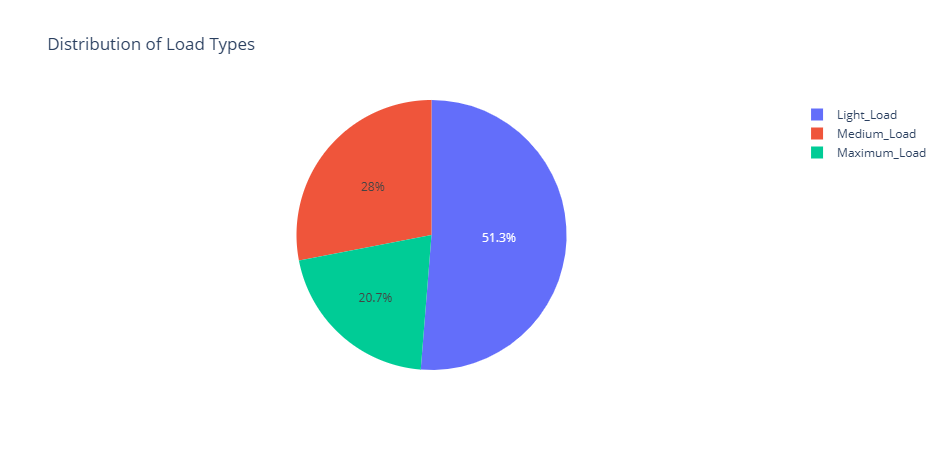

In [114]:
# Count the occurrences of each load type
load_type_counts = df['Load_Type'].value_counts()

# Create the pie chart
fig = go.Figure(data=[go.Pie(labels=load_type_counts.index, values=load_type_counts.values)])
fig.update_layout(title='Distribution of Load Types')
fig.show()

# Data Preprocessing & Transformation

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31354 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   date                                  31354 non-null  datetime64[ns]
 1   Usage_kWh                             31354 non-null  float64       
 2   Lagging_Current_Reactive.Power_kVarh  31354 non-null  float64       
 3   Leading_Current_Reactive_Power_kVarh  31354 non-null  float64       
 4   CO2(tCO2)                             31354 non-null  float64       
 5   Lagging_Current_Power_Factor          31354 non-null  float64       
 6   Leading_Current_Power_Factor          31354 non-null  float64       
 7   NSM                                   31354 non-null  int64         
 8   WeekStatus                            31354 non-null  object        
 9   Day_of_week                           31354 non-null  object        
 10  Loa

In [116]:
#count the value for load type 
df["Load_Type"].value_counts()

Load_Type
Light_Load      16075
Medium_Load      8789
Maximum_Load     6490
Name: count, dtype: int64

In [117]:
# Data Transformation:
# Encode Categorical Columns
categ = df.select_dtypes(include = "object").columns

columns_to_convert = ['NSM']
df[columns_to_convert] = df[columns_to_convert].astype(float)

le = LabelEncoder()
df[categ] = df[categ].apply(le.fit_transform)

In [118]:
#count the value for load type after LabelEncoder
df["Load_Type"].value_counts()

Load_Type
0    16075
2     8789
1     6490
Name: count, dtype: int64

By checking the value we can see that

0 = Light Load

2 = Medium Load

1 = Maximum Load

In [119]:
df.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,2018-01-01 00:15:00,3.17,2.95,0.0,0.0,73.21,100.0,900.0,0,1,0
1,2018-01-01 00:30:00,4.00,4.46,0.0,0.0,66.77,100.0,1800.0,0,1,0
2,2018-01-01 00:45:00,3.24,3.28,0.0,0.0,70.28,100.0,2700.0,0,1,0
3,2018-01-01 01:00:00,3.31,3.56,0.0,0.0,68.09,100.0,3600.0,0,1,0
4,2018-01-01 01:15:00,3.82,4.50,0.0,0.0,64.72,100.0,4500.0,0,1,0


In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31354 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   date                                  31354 non-null  datetime64[ns]
 1   Usage_kWh                             31354 non-null  float64       
 2   Lagging_Current_Reactive.Power_kVarh  31354 non-null  float64       
 3   Leading_Current_Reactive_Power_kVarh  31354 non-null  float64       
 4   CO2(tCO2)                             31354 non-null  float64       
 5   Lagging_Current_Power_Factor          31354 non-null  float64       
 6   Leading_Current_Power_Factor          31354 non-null  float64       
 7   NSM                                   31354 non-null  float64       
 8   WeekStatus                            31354 non-null  int64         
 9   Day_of_week                           31354 non-null  int64         
 10  Loa

In [121]:
df = df.drop('date', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31354 entries, 0 to 35039
Data columns (total 10 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Usage_kWh                             31354 non-null  float64
 1   Lagging_Current_Reactive.Power_kVarh  31354 non-null  float64
 2   Leading_Current_Reactive_Power_kVarh  31354 non-null  float64
 3   CO2(tCO2)                             31354 non-null  float64
 4   Lagging_Current_Power_Factor          31354 non-null  float64
 5   Leading_Current_Power_Factor          31354 non-null  float64
 6   NSM                                   31354 non-null  float64
 7   WeekStatus                            31354 non-null  int64  
 8   Day_of_week                           31354 non-null  int64  
 9   Load_Type                             31354 non-null  int64  
dtypes: float64(7), int64(3)
memory usage: 2.6 MB


In [122]:
# Data Augmentation
# Apply random noise
noisy_df = df.apply(lambda x: x + np.random.normal(0, 0.01, len(x)) if x.dtype == 'float' else x)

# Duplicate and shuffle
duplicated_df = pd.concat([df] * 2, ignore_index=True)
shuffled_df = shuffle(duplicated_df)

# Apply SMOTE
X = df.drop('Load_Type', axis=1)
y = df['Load_Type']

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

X_resampled['Load_Type'] = y_resampled
df_aug = X_resampled
df_aug.head()

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,3.17,2.95,0.0,0.0,73.21,100.0,900.0,0,1,0
1,4.00,4.46,0.0,0.0,66.77,100.0,1800.0,0,1,0
2,3.24,3.28,0.0,0.0,70.28,100.0,2700.0,0,1,0
3,3.31,3.56,0.0,0.0,68.09,100.0,3600.0,0,1,0
4,3.82,4.50,0.0,0.0,64.72,100.0,4500.0,0,1,0


In [123]:
df_aug.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48225 entries, 0 to 48224
Data columns (total 10 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Usage_kWh                             48225 non-null  float64
 1   Lagging_Current_Reactive.Power_kVarh  48225 non-null  float64
 2   Leading_Current_Reactive_Power_kVarh  48225 non-null  float64
 3   CO2(tCO2)                             48225 non-null  float64
 4   Lagging_Current_Power_Factor          48225 non-null  float64
 5   Leading_Current_Power_Factor          48225 non-null  float64
 6   NSM                                   48225 non-null  float64
 7   WeekStatus                            48225 non-null  int64  
 8   Day_of_week                           48225 non-null  int64  
 9   Load_Type                             48225 non-null  int64  
dtypes: float64(7), int64(3)
memory usage: 3.7 MB


In [124]:
#count the value for load type after data augmentstion
df_aug["Load_Type"].value_counts()

Load_Type
0    16075
2    16075
1    16075
Name: count, dtype: int64

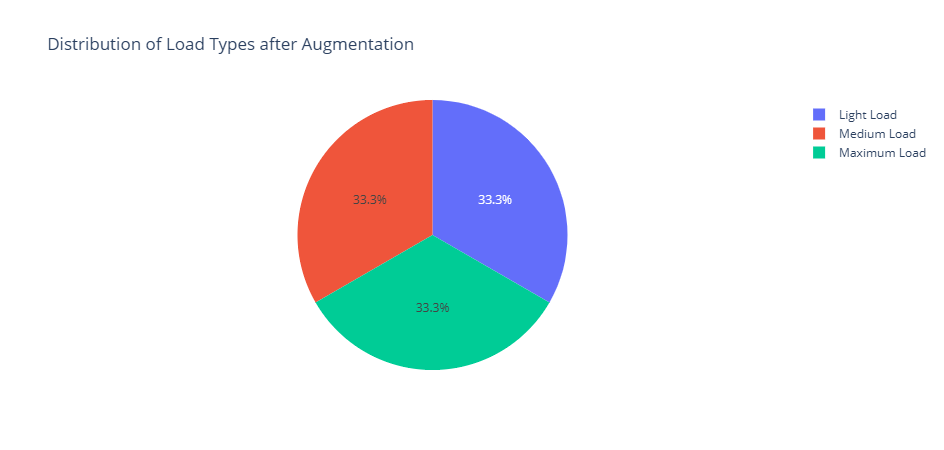

In [125]:
# Count the occurrences of each load type 
load_type_counts = df_aug['Load_Type'].value_counts()

labals_lis = ['Light Load',
              'Medium Load',
              'Maximum Load' ]

# Create the pie chart
fig = go.Figure(data=[go.Pie(labels=labals_lis, values=load_type_counts.values)])
fig.update_layout(title='Distribution of Load Types after Augmentation')
fig.show()

# Classification Models

### Feature Engineering

In [126]:
def feature_selection_using_RF(x,y):
    model = RandomForestClassifier()
    rfe = RFE(model, n_features_to_select=5)  # Choose the number of features to select
    rfe.fit(x, y)

    selected_features = x.columns[rfe.support_]
    importances = np.max(rfe.ranking_) + 1 - rfe.ranking_
    fig = px.bar(x=x.columns, y=importances, labels={'x': 'Feature', 'y': 'Importance'},
                     title='Feature Importances')
    fig.show()
    x = x[selected_features]
    return x,y

In [127]:
def dimensionality_reduction_with_pca(x):
    # Applying PCA
    pca = PCA(n_components=3) # n_components=3
    pca_components = pca.fit_transform(x)
    x = pd.DataFrame(pca_components, columns=['PC1', 'PC2','PC3'])

    # Plotting the explained variance
    explained_var = pca.explained_variance_ratio_
    cumulative_var = explained_var.cumsum()
    total_var = pca.explained_variance_ratio_.sum() * 100

    fig = px.area(
        x=range(1, len(cumulative_var)+1),
        y=cumulative_var,
        labels={"x": "Number of Components", "y": "Cumulative Explained Variance"},
        title=f"PCA Explained Variance Plot {total_var}"
    )
    fig.show()
    return x

In [128]:
x = df.drop(['Load_Type'], axis=1)
y = df.Load_Type

In [129]:
xg = df_aug.drop(['Load_Type'], axis=1)
yg = df_aug.Load_Type

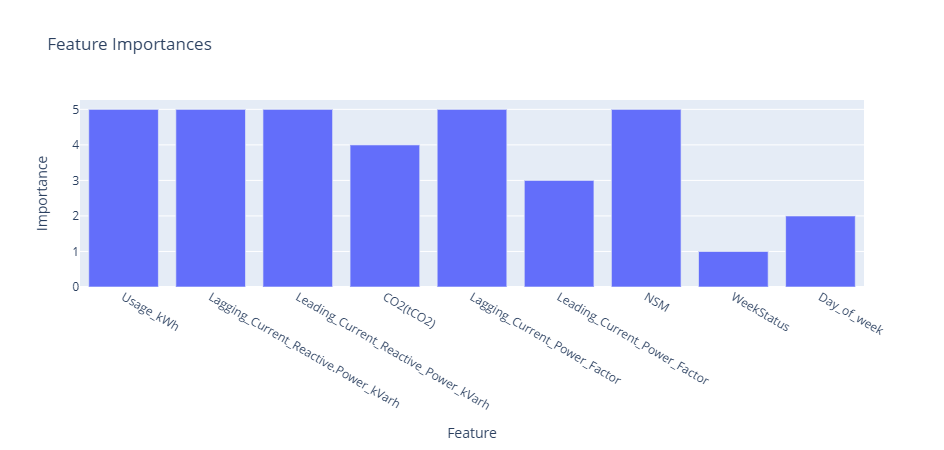

In [130]:
x , y = feature_selection_using_RF(x,y)

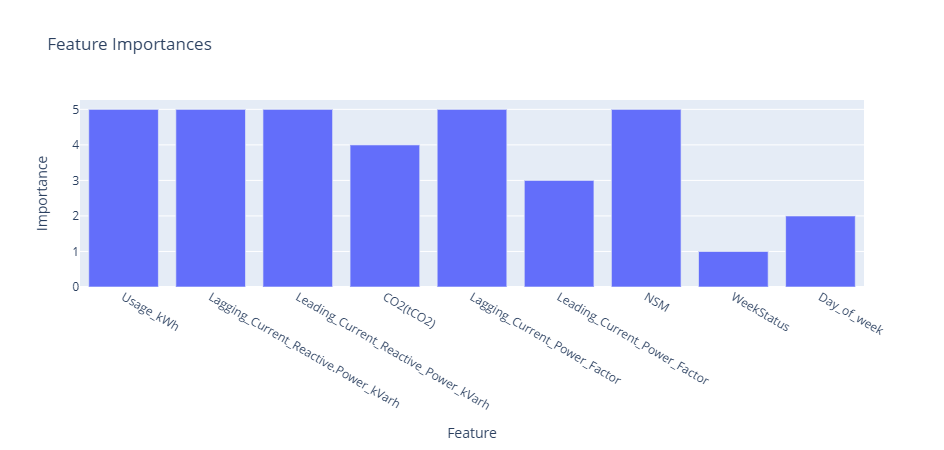

In [131]:
xg , yg = feature_selection_using_RF(xg,yg)

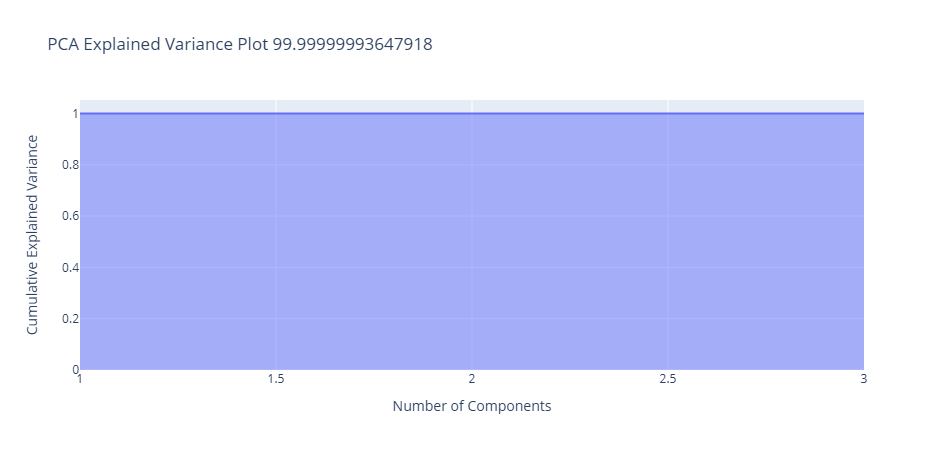

In [132]:
x = dimensionality_reduction_with_pca(x)

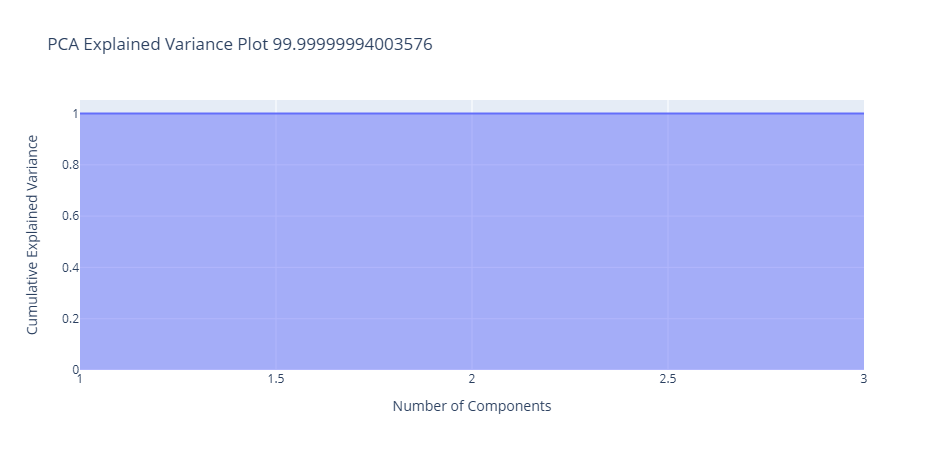

In [133]:
xg = dimensionality_reduction_with_pca(xg)

In [134]:
# Split the dataset and prepare some lists to store the models
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state = 42) 
xg_train, xg_test, yg_train, yg_test = train_test_split(xg, yg, test_size=0.25, random_state = 42)

### Model Training

In [135]:
#Loop for the training model 
models = []
 
names = [
    "Logistic Regression",
    "KNN",
    "Decision Tree",
    "Naive Bayes",
    "Random Forest",
    "Random Forest with Extra Trees",
    "AdaBoost",
    "XGBoost"
]
 
clf = [
    LogisticRegression(),
    KNeighborsClassifier(3),
    DecisionTreeClassifier(max_depth=5),
    GaussianNB(),
    RandomForestClassifier(n_estimators=200, max_leaf_nodes=16),
    ExtraTreesClassifier(),
    AdaBoostClassifier(DecisionTreeClassifier(max_depth=3)),
    xgb.XGBClassifier()
]

In [136]:
def train_clf(x_train, y_train,x_test, y_test):
    scores = []
    for model in tqdm(clf):
        model.fit(x_train, y_train)
        score = model.score(x_test, y_test)
        scores.append(score)
#         print(model)
#         print(score)
    return pd.DataFrame(zip(names,scores), columns=['Classifier', 'Accuracy'])

  0%|          | 0/8 [00:00<?, ?it/s]

                       Classifier  Accuracy
7                         XGBoost  0.887231
5  Random Forest with Extra Trees  0.878811
1                             KNN  0.869371
2                   Decision Tree  0.864141
4                   Random Forest  0.856742
6                        AdaBoost  0.821533
0             Logistic Regression  0.698048
3                     Naive Bayes  0.636178


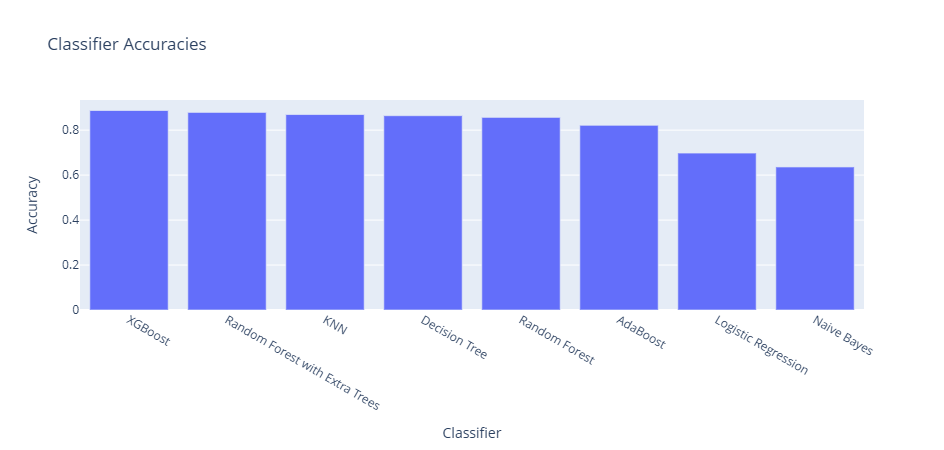

In [137]:
#List the classifier and their accuracy
scores_df = train_clf(x_train, y_train,x_test, y_test)
scores_df = scores_df.sort_values(by=['Accuracy'], ascending=[False])
print(scores_df)

# Plot the accuracies using Plotly Express
fig = px.bar(scores_df, x='Classifier', y='Accuracy', labels={'Classifier': 'Classifier', 'Accuracy': 'Accuracy'},
             title='Classifier Accuracies')
fig.update_layout(xaxis_title='Classifier', yaxis_title='Accuracy')
fig.show()

  0%|          | 0/8 [00:00<?, ?it/s]

                       Classifier  Accuracy
7                         XGBoost  0.887231
5  Random Forest with Extra Trees  0.878811
1                             KNN  0.869371
2                   Decision Tree  0.864141
4                   Random Forest  0.856742
6                        AdaBoost  0.821533
0             Logistic Regression  0.698048
3                     Naive Bayes  0.636178


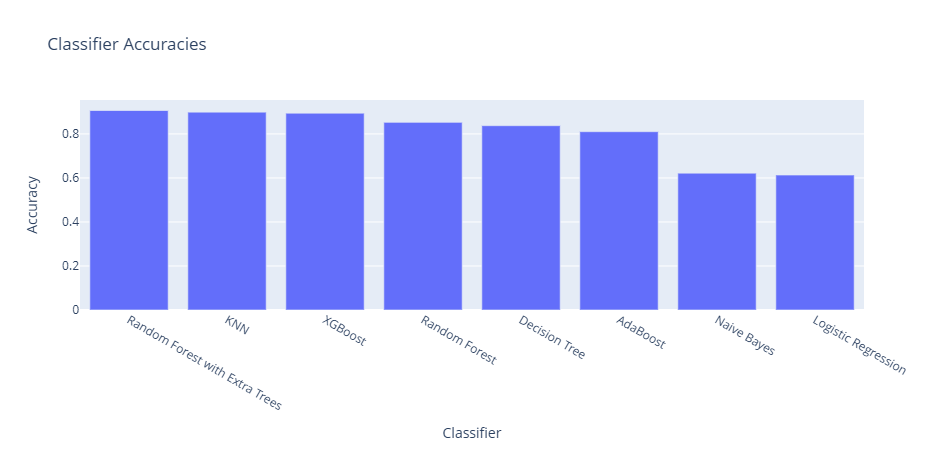

In [138]:
#List the classifier and their accuracy
scores_df_aug = train_clf(xg_train, yg_train,xg_test, yg_test)
scores_df_aug = scores_df_aug.sort_values(by=['Accuracy'], ascending=[False])
print(scores_df)

# Plot the accuracies using Plotly Express
fig = px.bar(scores_df_aug, x='Classifier', y='Accuracy', labels={'Classifier': 'Classifier', 'Accuracy': 'Accuracy'},
             title='Classifier Accuracies')
fig.update_layout(xaxis_title='Classifier', yaxis_title='Accuracy')
fig.show()

In [139]:
#Naive grid search implementation
parameters = {'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]}
CBC = xgb.XGBClassifier()
Grid_CBC = GridSearchCV(estimator=CBC, param_grid = parameters, cv = 2, n_jobs=-1)
Grid_CBC.fit(xg_train, yg_train)

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 10),
                         'n_estimators': range(60, 220, 40)})

In [140]:
print("Results from Grid Search" )
print("\n The best estimator across ALL searched params:\n",Grid_CBC.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)

Results from Grid Search

 The best estimator across ALL searched params:
 XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=180, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

 The best score across ALL searched params:
 0.8885478876354789

 The best parameters across ALL searched params:
 {'learning_rate': 0.1, 'max_depth': 9, 'n_estim

In [141]:
#This is the classification model with the best parameters
Grid_CBC

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 10),
                         'n_estimators': range(60, 220, 40)})

In [142]:
# Make predictions on the test set
yg_pred = Grid_CBC.predict(xg_test)

### Model Evaluation

In [143]:
# Calculate evaluation metrics
def cls_report(y_test, y_pred):
    y_test_binarized = label_binarize(y_test, classes=[0, 1, 2]) 
    n_classes = y_test_binarized.shape[1]
    y_pred_reshaped = y_pred.reshape(-1, 1)
    class_report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test_binarized, y_pred_reshaped)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return class_report, conf_matrix, roc_auc, mse, r2

In [144]:
class_report, conf_matrix, roc_auc, mse, r2 = cls_report(yg_test, yg_pred)

AUC-ROC: 0.0416
Mean Squared Error: 0.16546404578253296
R-squared: 0.7534406375727135

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      4090
           1       0.85      0.93      0.89      3965
           2       0.88      0.83      0.85      4002

    accuracy                           0.90     12057
   macro avg       0.90      0.90      0.90     12057
weighted avg       0.90      0.90      0.90     12057

Confusion Matrix:
[[3883   31  176]
 [  13 3671  281]
 [  89  610 3303]]


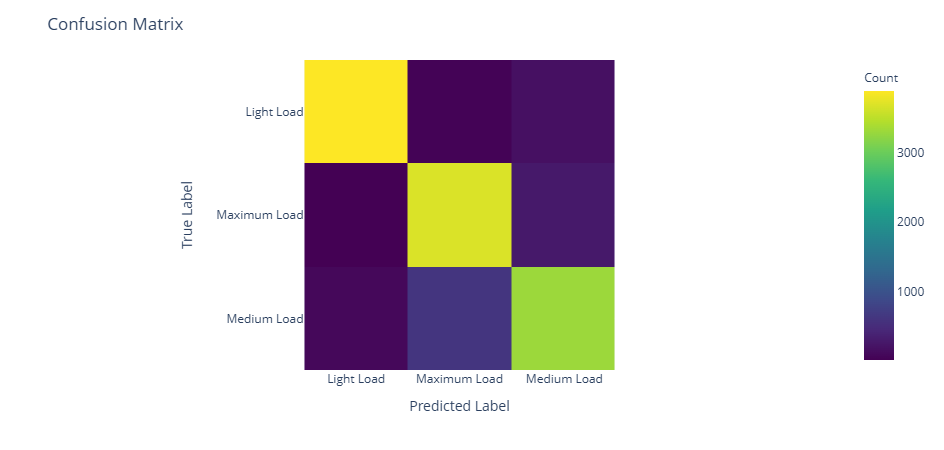

In [145]:
# Print the results
print(f"AUC-ROC: {roc_auc:.4f}")
print('Mean Squared Error:', mse)
print('R-squared:', r2)
print("\nClassification Report:")
print(class_report)
print("Confusion Matrix:")
print(conf_matrix)

# Create a DataFrame for the confusion matrix
classes = ['Light Load','Maximum Load' ,  ' Medium Load']
df_cm = pd.DataFrame(conf_matrix, index=classes, columns=classes)

# Plot the confusion matrix heatmap using Plotly Express
fig = px.imshow(df_cm,
                labels=dict(x="Predicted Label", y="True Label", color="Count"),
                x=classes,
                y=classes,
                color_continuous_scale='Viridis')

# Customize the layout
fig.update_layout(title='Confusion Matrix',
                  xaxis_title='Predicted Label',
                  yaxis_title='True Label')

# Show the plot
fig.show()

# Regression Models

### Feature Engineering

In [146]:
def feature_selection_using_RFR(x,y):
    model = RandomForestRegressor()
    rfe = RFE(model, n_features_to_select=5)  # Choose the number of features to select
    rfe.fit(x, y)

    selected_features = x.columns[rfe.support_]
    importances = np.max(rfe.ranking_) + 1 - rfe.ranking_
    fig = px.bar(x=x.columns, y=importances, labels={'x': 'Feature', 'y': 'Importance'},
                     title='Feature Importances')
    fig.show()
    x = x[selected_features]
    return x,y

In [147]:
# Split the dataset and prepare some lists to store the models
x = df.drop(['Usage_kWh'], axis=1)
y = df.Usage_kWh

In [148]:
# Split the dataset and prepare some lists to store the models
xg = df_aug.drop(['Usage_kWh'], axis=1)
yg = df_aug.Usage_kWh

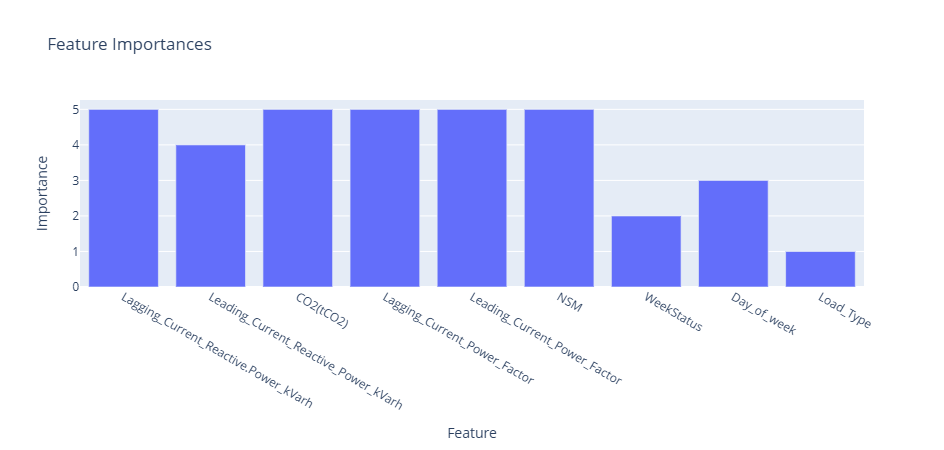

In [149]:
x , y = feature_selection_using_RFR(x,y)

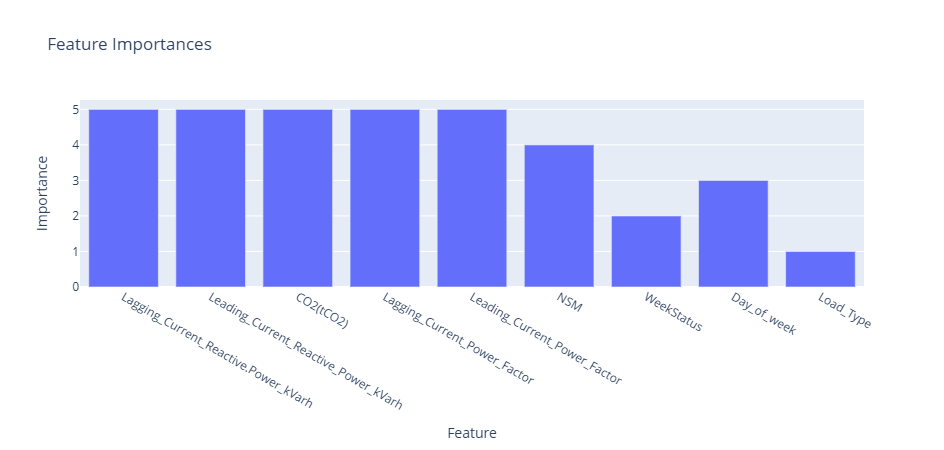

In [150]:
xg , yg = feature_selection_using_RFR(xg,yg)

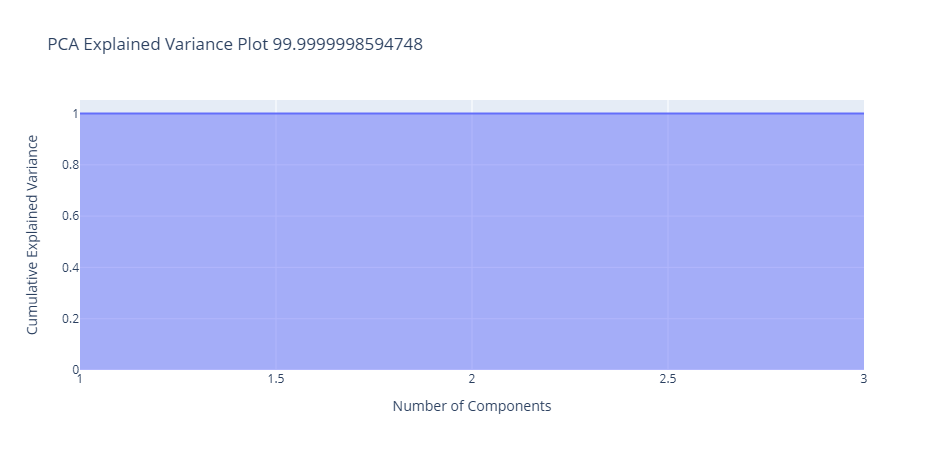

In [151]:
x = dimensionality_reduction_with_pca(x)

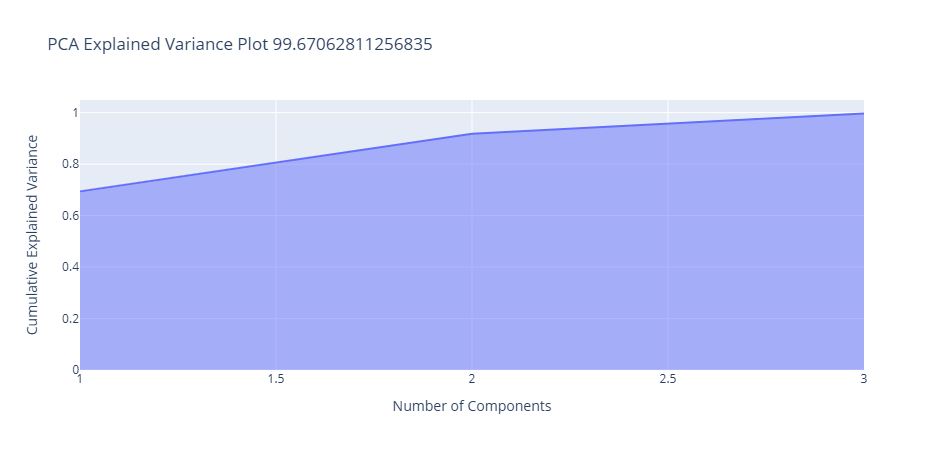

In [152]:
xg = dimensionality_reduction_with_pca(xg)

In [153]:
# Split the dataset and prepare some lists to store the models
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state = 42) 
xg_train, xg_test, yg_train, yg_test = train_test_split(xg, yg, test_size=0.25, random_state = 42) 

### Model Trainging

In [211]:
#Loop for the training model 
models = []
 
names = [
    "Linear Regression",
    "Ridge Regression",
    "Decision Tree Regression",
    "Random Forest Regression",
    "Gradient Boosting Regression",
    "KNN Regression",
    "Bayesian Ridge Regression",
    "XGBoost Regression"
]
 
reg = [
    LinearRegression(),
    Ridge(alpha=0.5),
    DecisionTreeRegressor(max_depth=5),
    RandomForestRegressor(n_estimators=5,max_depth=5),
    GradientBoostingRegressor(),
    KNeighborsRegressor(n_neighbors=35,leaf_size=50),
    BayesianRidge(),
    xgb.XGBRegressor()
]

In [212]:
def train_reg(x_train, y_train,x_test, y_test):
    scores = []
    for model in tqdm(reg):
        model.fit(x_train, y_train)
        score = model.score(x_test, y_test)
        scores.append(score)
#         print(model)
#         print(score)
    return pd.DataFrame(zip(names,scores), columns=['Regressor', 'Accuracy'])

  0%|          | 0/8 [00:00<?, ?it/s]

                      Regressor  Accuracy
7            XGBoost Regression  0.998351
4  Gradient Boosting Regression  0.993561
3      Random Forest Regression  0.981738
2      Decision Tree Regression  0.978033
5                KNN Regression  0.957728
0             Linear Regression  0.896736
1              Ridge Regression  0.896736
6     Bayesian Ridge Regression  0.896736


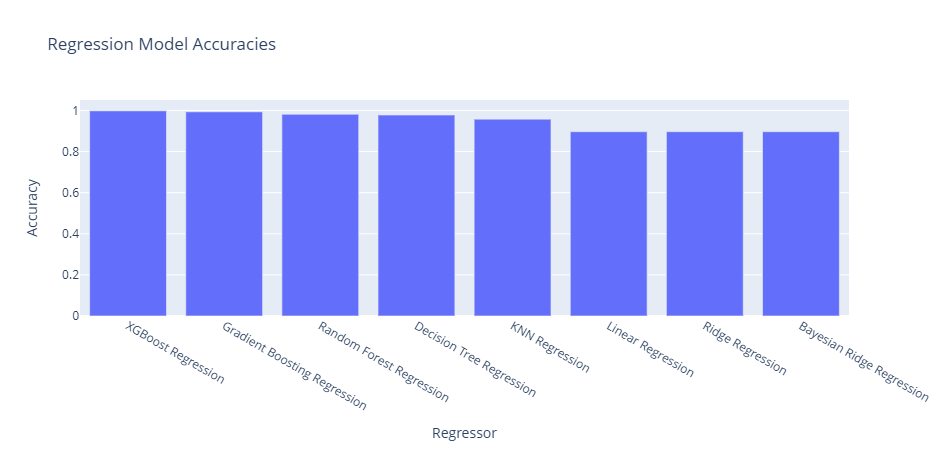

In [213]:
#List the classifier and their accuracy
scores_df = train_reg(x_train, y_train,x_test, y_test)
scores_df = scores_df.sort_values(by=['Accuracy'], ascending=[False])
print(scores_df)

# Plot the accuracies using Plotly Express
fig = px.bar(scores_df, x='Regressor', y='Accuracy', labels={'Regressor': 'Regressor', 'Accuracy': 'Accuracy'},
             title='Regression Model Accuracies')
fig.update_layout(xaxis_title='Regressor', yaxis_title='Accuracy')
fig.show()

  0%|          | 0/8 [00:00<?, ?it/s]

                      Regressor  Accuracy
7            XGBoost Regression  0.998691
5                KNN Regression  0.998337
4  Gradient Boosting Regression  0.995073
3      Random Forest Regression  0.982627
2      Decision Tree Regression  0.978339
0             Linear Regression  0.919673
1              Ridge Regression  0.919673
6     Bayesian Ridge Regression  0.919673


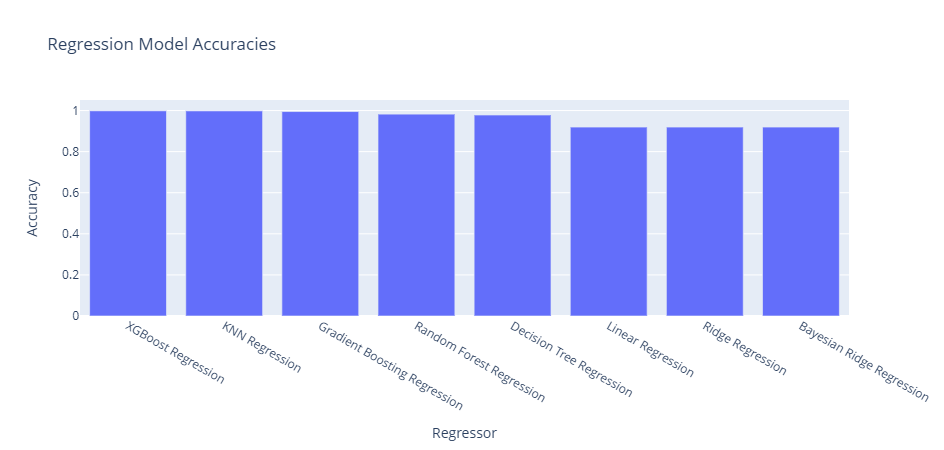

In [214]:
#List the classifier and their accuracy
scores_df_aug = train_reg(xg_train, yg_train,xg_test, yg_test)
scores_df_aug = scores_df_aug.sort_values(by=['Accuracy'], ascending=[False])
print(scores_df_aug)

# Plot the accuracies using Plotly Express
fig = px.bar(scores_df_aug, x='Regressor', y='Accuracy', labels={'Regressor': 'Regressor', 'Accuracy': 'Accuracy'},
             title='Regression Model Accuracies')
fig.update_layout(xaxis_title='Regressor', yaxis_title='Accuracy')
fig.show()

In [215]:
#Naive grid search implementation
parameters = {'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]}
CBC = xgb.XGBRegressor()
Grid_CBC = GridSearchCV(estimator=CBC, param_grid = parameters, cv = 2, n_jobs=-1)
Grid_CBC.fit(xg_train, yg_train)

GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 10),
                         'n_estimators': range(60, 220, 40)})

In [216]:
print("Results from Grid Search" )
print("\n The best estimator across ALL searched params:\n",Grid_CBC.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)

Results from Grid Search

 The best estimator across ALL searched params:
 XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=180, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

 The best score across ALL searched params:
 0.9985535279832705

 The best parameters across ALL searched params:
 {'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 180}


In [217]:
#This is the classification model with the best parameters
Grid_CBC

GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 10),
                         'n_estimators': range(60, 220, 40)})

In [218]:
# Make predictions on the test set
yg_pred = Grid_CBC.predict(xg_test)

### Model Evaluation

In [219]:
def regression_report(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    evs = explained_variance_score(y_true, y_pred)
    
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("Mean Absolute Error (MAE):", mae)
    print("R-squared (R2) Score:", r2)
    print("Explained Variance Score:", evs)

In [220]:
regression_report(yg_test, yg_pred)

Mean Squared Error (MSE): 1.4454048506082338
Root Mean Squared Error (RMSE): 1.2022499118769914
Mean Absolute Error (MAE): 0.49470649095623037
R-squared (R2) Score: 0.9987952880678298
Explained Variance Score: 0.9987957576809747
